# **Exponential Low Pass Filter For Root Zone Soil Moisture (RZSM) Estimation in Twente Region**

* Author: Calvin Samwel Swai, July 2024




# **Introduction**

In this notebook Exponential Low Pass Filter (ELPF) workflow for Root Zone Soil Moisture (RZSM) is introduced. This notebook is designed to implement the analytical principles of ELPF to retrieve RZSM time series from Surface Soil Moisture (SSM). This notebook was prepared as a part of the thesis objective designed to compare the capacity of both statistical and analytical approaches to retrieve RZSM from SSM in Twente region. For detailed information on the results please refer the accompanying report.

Details about the methodology design can also be found in the methodolgy section.

1. Preparations and Environment sett-up.
* This section involves preliminary steps such as installing and importing necessary libraries, as well as configuring the working environment.


2. Data input.
* Location of interest, In-situ Soil Moisture and grid Soil moisture records

3. Data processing and cleaning.
* SI unit conversions and in-situRZSM computations were the primary data cleaning procedures conducted in this notebook.
Additional processing includes date and time column definition, temporal matching data time series, and finally outlier detection through scatterplots

4. Low Pass Filter Application
* After creating a subset of time series of interest, ELPF algorithm was iterated through the dataset, station specific calibration to determine the optimal delayed T for each study period. The optimal T value was determined as the one which yield the highest correlation score with the in-situ time series.
The recursive ELPF formular introduced by Albergel et al., (2008) was adopted in this notebook.

5. Anomalies detection


# **1. Preparations and Environment Setting up**

**a. Importing useful libraries**

In [ ]:
#Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import ee
import geemap
import geemap.colormaps as cm

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-ngorongoro')

**b. Connecting to the working directory**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
workdr= '/content/drive/MyDrive/Tafiti'

**c. Displaying the area of interest**

In [ ]:
+# Load the polygon shapefile from Google Drive (replace with your path)
sm_stations = ee.FeatureCollection('users/calvinsamwel94/Twente_SM_Stations')
polygon = ee.FeatureCollection('users/calvinsamwel94/Overisal_Boundary')

In [ ]:
# Calculate the centroid of the polygon
centroid = polygon.geometry().centroid()
centroid_coords = centroid.getInfo()['coordinates'][::-1]  # Reverse the coordinates (lat, lon)

# Create a map centered around the centroid of the polygon
Map = geemap.Map(center=centroid_coords, zoom=10)

# Add the polygon to the map
Map.addLayer(polygon, {}, 'Polygon')
Map.addLayer(sm_stations, {}, 'SM Points')

# Display the map
Map

Map(center=[52.44489991554625, 6.449001897190261], controls=(WidgetControl(options=['position', 'transparent_b…

# **2. Data input**


In [ ]:
sm_stations = ee.FeatureCollection('users/calvinsamwel94/Twente_SM_Stations')
sm_stations=ee.FeatureCollection(sm_stations).filter(
  ee.Filter.inList('Station_ID', ['ITCSM_14']))

**a. Insitu Soil Moisture time series**

In [ ]:
insitu_sm=pd.read_csv('/content/drive/MyDrive/Tafiti/Insitu_SM/ITCSM_14.csv')

insitu_sm.head()

Date_time  _5_cm_SM  _5_cm_ST  _10_cm_SM  _10_cm_ST  _20_cm_SM  \
0  01/01/2008 00:00   -99.999     -99.9    -99.999      -99.9    -99.999   
1  01/01/2008 00:15   -99.999     -99.9    -99.999      -99.9    -99.999   
2  01/01/2008 00:30   -99.999     -99.9    -99.999      -99.9    -99.999   
3  01/01/2008 00:45   -99.999     -99.9    -99.999      -99.9    -99.999   
4  01/01/2008 01:00   -99.999     -99.9    -99.999      -99.9    -99.999   

   _20_cm_ST  _40_cm_SM  _40_cm_ST  _80_cm_SM  _80_cm_ST  
0      -99.9    -99.999      -99.9    -99.999      -99.9  
1      -99.9    -99.999      -99.9    -99.999      -99.9  
2      -99.9    -99.999      -99.9    -99.999      -99.9  
3      -99.9    -99.999      -99.9    -99.999      -99.9  
4      -99.9    -99.999      -99.9    -99.999      -99.9

**b. Grid Surface Soil Moisture**

In [ ]:
NL = ee.FeatureCollection("users/qianrswaterr/GlobalSSM/gadm36_NLD_0")
Map.addLayer(NL)
SM_RF_1km=ee.ImageCollection('users/qianrswaterr/GlobalSSM1km0509')


for i in range(2000, 2001):
  #filter the data in time
  image2000 = SM_RF_1km.filterMetadata('system:index','contains',str(i))
  #filter the data in space
  image2000 = image2000.filterMetadata('system:index','contains','Europe')
  image2000 = image2000.filterMetadata('system:index','ends_with','1km').first()
  print("Image for year", i)
  print(image2000.getInfo())
  #image=image.clip(NL)
  #Map.addLayer(image)



Image for year 2000
{'type': 'Image', 'bands': [{'id': 'band_2000_03_05_classification', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [11158, 5224], 'crs': 'EPSG:4326', 'crs_transform': [0.008983152841195215, 0, -31.29730449872413, 0, -0.008983152841195215, 81.8544886889708]}, {'id': 'band_2000_03_06_classification', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [11158, 5224], 'crs': 'EPSG:4326', 'crs_transform': [0.008983152841195215, 0, -31.29730449872413, 0, -0.008983152841195215, 81.8544886889708]}, {'id': 'band_2000_03_07_classification', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [11158, 5224], 'crs': 'EPSG:4326', 'crs_transform': [0.008983152841195215, 0, -31.29730449872413, 0, -0.008983152841195215, 81.8544886889708]}, {'id': 'band_2000_03_08_classification', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65

In [ ]:
start_year = 2001
end_year = 2020

# Create an empty image to store stacked bands
image_stack = ee.Image(image2000)

# Iterate over each year in the date range
for i in range(start_year, end_year + 1):
    # Filter the data in time
    image = (SM_RF_1km
             .filterMetadata('system:index', 'contains', str(i))
             # Filter the data in space
             .filterMetadata('system:index', 'contains', 'Europe')
             .filterMetadata('system:index', 'ends_with', '1km')
             .first())

    # Add the current image's bands to the image stack
    image_stack = image_stack.addBands(image)

# Print the stacked image
print("Stacked Image:", image_stack.getInfo())


Stacked Image: {'type': 'Image', 'bands': [{'id': 'band_2000_03_05_classification', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [11158, 5224], 'crs': 'EPSG:4326', 'crs_transform': [0.008983152841195215, 0, -31.29730449872413, 0, -0.008983152841195215, 81.8544886889708]}, {'id': 'band_2000_03_06_classification', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [11158, 5224], 'crs': 'EPSG:4326', 'crs_transform': [0.008983152841195215, 0, -31.29730449872413, 0, -0.008983152841195215, 81.8544886889708]}, {'id': 'band_2000_03_07_classification', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [11158, 5224], 'crs': 'EPSG:4326', 'crs_transform': [0.008983152841195215, 0, -31.29730449872413, 0, -0.008983152841195215, 81.8544886889708]}, {'id': 'band_2000_03_08_classification', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535},

In [ ]:

# Define a function to extract band values from the image at each point
def extract_band_values(feature):
    point = feature.geometry()
    values = image_stack.sample(point).first().toDictionary()
    return feature.set(values)

# Map the extraction function over the points FeatureCollection
try:
    extracted_data = sm_stations.map(extract_band_values).getInfo()
    print("Extraction successful!")
    print("Extracted Data:", extracted_data)
except Exception as e:
    print("Error during extraction:", e)
    extracted_data = None

Extraction successful!
Extracted Data: {'type': 'FeatureCollection', 'columns': {}, 'version': 1695217045456189, 'id': 'users/calvinsamwel94/Twente_SM_Stations', 'properties': {'system:asset_size': 12826}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [6.317221839719936, 52.191668675785735]}, 'id': '00000000000000000013', 'properties': {'SM_10m_201': -9999, 'SM_10m_202': -9999, 'SM_10m_203': -9999, 'SM_10m_204': -9999, 'SM_10m_205': -9999, 'SM_10m_206': -9999, 'Station_ID': 'ITCSM_14', 'band_2000_03_05_classification': 387, 'band_2000_03_06_classification': 352, 'band_2000_03_07_classification': 346, 'band_2000_03_08_classification': 348, 'band_2000_03_09_classification': 355, 'band_2000_03_10_classification': 379, 'band_2000_03_11_classification': 354, 'band_2000_03_12_classification': 341, 'band_2000_03_13_classification': 347, 'band_2000_03_14_classification': 348, 'band_2000_03_15_classification': 372, 'band_2000_03_16_classification': 345, 'band_200

In [ ]:
# Define a function to extract band values from the image at each point
def extract_band_values(feature):
    point = feature.geometry()
    values = image_stack.sample(point).first().toDictionary()
    return ee.Feature(point).set(values)

# Map the extraction function over the points FeatureCollection
try:
    extracted_data = sm_stations.map(extract_band_values).getInfo()
    print("Extraction successful!")
    print("Extracted Data:", extracted_data)
except Exception as e:
    print("Error during extraction:", e)
    extracted_data = None


Extraction successful!
Extracted Data: {'type': 'FeatureCollection', 'columns': {}, 'version': 1695217045456189, 'id': 'users/calvinsamwel94/Twente_SM_Stations', 'properties': {'system:asset_size': 12826}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [6.317221839719936, 52.191668675785735]}, 'id': '00000000000000000013', 'properties': {'band_2000_03_05_classification': 387, 'band_2000_03_06_classification': 352, 'band_2000_03_07_classification': 346, 'band_2000_03_08_classification': 348, 'band_2000_03_09_classification': 355, 'band_2000_03_10_classification': 379, 'band_2000_03_11_classification': 354, 'band_2000_03_12_classification': 341, 'band_2000_03_13_classification': 347, 'band_2000_03_14_classification': 348, 'band_2000_03_15_classification': 372, 'band_2000_03_16_classification': 345, 'band_2000_03_17_classification': 338, 'band_2000_03_18_classification': 349, 'band_2000_03_19_classification': 328, 'band_2000_03_20_classification': 331, 'band

In [ ]:
feature_list = extracted_data['features']

In [ ]:
import pandas as pd
# Convert the FeatureCollection to a list of dictionaries
#feature_list = extracted_data.getInfo()['features']

# Initialize an empty list to store dictionaries for each feature
data_list = []

# Iterate over features and extract properties
for feature in feature_list:
    properties = feature['properties']
    data_list.append(properties)

# Convert the list of dictionaries to a Pandas DataFrame
df = pd.DataFrame(data_list)

df.head()

band_2000_03_05_classification  band_2000_03_06_classification  \
0                             387                             352   

   band_2000_03_07_classification  band_2000_03_08_classification  \
0                             346                             348   

   band_2000_03_09_classification  band_2000_03_10_classification  \
0                             355                             379   

   band_2000_03_11_classification  band_2000_03_12_classification  \
0                             354                             341   

   band_2000_03_13_classification  band_2000_03_14_classification  ...  \
0                             347                             348  ...   

   band_2020_12_22_classification  band_2020_12_23_classification  \
0                             350                             362   

   band_2020_12_24_classification  band_2020_12_25_classification  \
0                             365                             398   

   band_2020_12_26_classification  band_2020_12_27_classification  \
0                             394                             372   

   band_2020_12_28_classification  band_2020_12_29_classification  \
0                             388                             384   

   band_2020_12_30_classification  band_2020_12_31_classification  
0                             382                             380  

[1 rows x 7549 columns]

In [ ]:
columns=df.columns
# Extract the date information from the column names
df['date'] = pd.to_datetime(df.columns.str.extract(r'band_(\d{4}_\d{2}_\d{2})')[0], format='%Y_%m_%d')

# Melt the DataFrame
melted_df = pd.melt(df, id_vars=['date'], value_vars=columns, var_name='Date', value_name='SM')

# Print the reshaped DataFrame
print(melted_df)

           date                            Date   SM
0    2000-03-05  band_2000_03_05_classification  387
1    2000-03-05  band_2000_03_06_classification  352
2    2000-03-05  band_2000_03_07_classification  346
3    2000-03-05  band_2000_03_08_classification  348
4    2000-03-05  band_2000_03_09_classification  355
...         ...                             ...  ...
7544 2000-03-05  band_2020_12_27_classification  372
7545 2000-03-05  band_2020_12_28_classification  388
7546 2000-03-05  band_2020_12_29_classification  384
7547 2000-03-05  band_2020_12_30_classification  382
7548 2000-03-05  band_2020_12_31_classification  380

[7549 rows x 3 columns]


In [ ]:
df_filtered = melted_df[melted_df['Date'] != 'SM_10m_203']
df_filtered = df_filtered[df_filtered['Date'] != 'SM_10m_201']
df_filtered = df_filtered[df_filtered['Date'] != 'SM_10m_202']
df_filtered = df_filtered[df_filtered['Date'] != 'SM_10m_204']
df_filtered = df_filtered[df_filtered['Date'] != 'SM_10m_205']
df_filtered = df_filtered[df_filtered['Date'] != 'SM_10m_206']
df_filtered = df_filtered[df_filtered['Date'] != 'Station_ID']
df_filtered = df_filtered[df_filtered['Date'] != 'latitude__']
df_filtered = df_filtered[df_filtered['Date'] != 'longitude']
df_filtered = df_filtered[df_filtered['Date'] != 'status']

In [ ]:
df_filtered['Date'] = df_filtered['Date'].str.extract(r'band_(\d{4}_\d{2}_\d{2})_classification', expand=False)


# **3. Data cleaning, processing, and exploration**

In [ ]:
df_filtered['Date'] = df_filtered['Date'].str.replace('_', '/')
df_filtered['Date']=pd.to_datetime(df_filtered['Date'], errors='coerce')
df_filtered['SSM']=df_filtered['SM']/1000
df_filtered=df_filtered[['Date','SSM']].reset_index(drop=True)


In [ ]:
df_filtered

Date    SSM
0    2000-03-05  0.387
1    2000-03-06  0.352
2    2000-03-07  0.346
3    2000-03-08  0.348
4    2000-03-09  0.355
...         ...    ...
7544 2020-12-27  0.372
7545 2020-12-28  0.388
7546 2020-12-29  0.384
7547 2020-12-30  0.382
7548 2020-12-31  0.380

[7549 rows x 2 columns]

In [ ]:
insitu_sm['Date_time'] = insitu_sm['Date_time'].astype(str)
insitu_sm[['Date', 'time']] = insitu_sm['Date_time'].str.split(expand=True)

insitu_sm.head()

Date_time  _5_cm_SM  _5_cm_ST  _10_cm_SM  _10_cm_ST  _20_cm_SM  \
0  01/01/2008 00:00   -99.999     -99.9    -99.999      -99.9    -99.999   
1  01/01/2008 00:15   -99.999     -99.9    -99.999      -99.9    -99.999   
2  01/01/2008 00:30   -99.999     -99.9    -99.999      -99.9    -99.999   
3  01/01/2008 00:45   -99.999     -99.9    -99.999      -99.9    -99.999   
4  01/01/2008 01:00   -99.999     -99.9    -99.999      -99.9    -99.999   

   _20_cm_ST  _40_cm_SM  _40_cm_ST  _80_cm_SM  _80_cm_ST        Date   time  
0      -99.9    -99.999      -99.9    -99.999      -99.9  01/01/2008  00:00  
1      -99.9    -99.999      -99.9    -99.999      -99.9  01/01/2008  00:15  
2      -99.9    -99.999      -99.9    -99.999      -99.9  01/01/2008  00:30  
3      -99.9    -99.999      -99.9    -99.999      -99.9  01/01/2008  00:45  
4      -99.9    -99.999      -99.9    -99.999      -99.9  01/01/2008  01:00

In [ ]:
# Convert 'Date' column to datetime object
insitu_sm['Date'] = pd.to_datetime(insitu_sm['Date'], format='%d/%m/%Y')

# Group by date and calculate daily mean
insitu_sm = insitu_sm.drop(columns=['Date_time', 'time']).groupby('Date').mean()

insitu_sm.reset_index(inplace=True)

# Convert 'Date' column back to the desired format
insitu_sm['Date'] = insitu_sm['Date'].dt.strftime('%d-%m-%Y')


In [ ]:
#Make error values =np.nan
insitu_sm.loc[:, insitu_sm.columns[1:11]] = insitu_sm.loc[:, insitu_sm.columns[1:11]].where(insitu_sm.loc[:, insitu_sm.columns[1:11]] >= 0, np.nan)


In [ ]:
gssm=df_filtered
gssm['Date'] = gssm['Date'].dt.strftime('%d-%m-%Y')
gssm

Date    SSM
0     05-03-2000  0.387
1     06-03-2000  0.352
2     07-03-2000  0.346
3     08-03-2000  0.348
4     09-03-2000  0.355
...          ...    ...
7544  27-12-2020  0.372
7545  28-12-2020  0.388
7546  29-12-2020  0.384
7547  30-12-2020  0.382
7548  31-12-2020  0.380

[7549 rows x 2 columns]

In [ ]:
# Convert 'Date' column to datetime object
gssm['Date'] = pd.to_datetime(gssm['Date'], format='%d-%m-%Y')

# Group by date and calculate daily mean
gssm = gssm.groupby('Date').mean()

gssm.reset_index(inplace=True)

# Convert 'Date' column back to the desired format
gssm['Date'] = gssm['Date'].dt.strftime('%d-%m-%Y')


<Axes: xlabel='_5_cm_SM', ylabel='Count'>

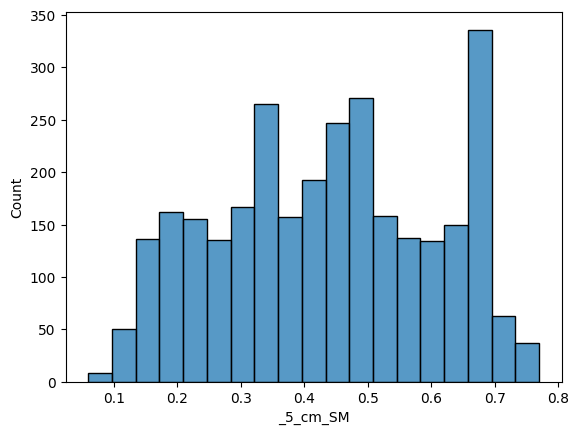

In [ ]:
sns.histplot(insitu_sm['_5_cm_SM'])

<Axes: xlabel='SSM', ylabel='Count'>

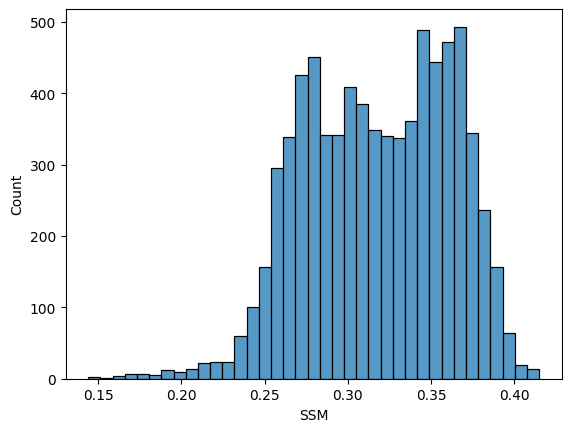

In [ ]:
sns.histplot(gssm['SSM'])

In [ ]:
gssm_cleaned = gssm.dropna(subset=['SSM'])
insitu_sm_cleaned = insitu_sm.dropna(subset=['_5_cm_SM'])
correlation=gssm_cleaned['SSM'].corr(insitu_sm_cleaned['_5_cm_SM'])
correlation

-0.2549541152266948

In [ ]:
print("Unique values in 'SSM':", gssm['SSM'].nunique())

Unique values in 'SSM': 241


In [ ]:
print("Unique values in '_5_cm_SM':", insitu_sm['_5_cm_SM'].nunique())

Unique values in '_5_cm_SM': 2859


In [ ]:
gssm.head()

Date    SSM
0  05-03-2000  0.387
1  06-03-2000  0.352
2  07-03-2000  0.346
3  08-03-2000  0.348
4  09-03-2000  0.355

In [ ]:
#Merging Insistu and grid SM dataset
gssm_insitu=pd.merge(gssm,insitu_sm[['Date','_5_cm_SM','_10_cm_SM','_20_cm_SM','_40_cm_SM']], on= 'Date', how='left').reset_index(drop=True)
gssm_insitu = gssm_insitu.dropna(subset=['SSM']).reset_index(drop=True)
gssm_insitu

Date    SSM  _5_cm_SM  _10_cm_SM  _20_cm_SM  _40_cm_SM
0     05-03-2000  0.387       NaN        NaN        NaN        NaN
1     06-03-2000  0.352       NaN        NaN        NaN        NaN
2     07-03-2000  0.346       NaN        NaN        NaN        NaN
3     08-03-2000  0.348       NaN        NaN        NaN        NaN
4     09-03-2000  0.355       NaN        NaN        NaN        NaN
...          ...    ...       ...        ...        ...        ...
7544  27-12-2020  0.372  0.634365   0.558708        NaN   0.447667
7545  28-12-2020  0.388  0.639500   0.560510        NaN   0.447000
7546  29-12-2020  0.384  0.640146   0.557354        NaN   0.448625
7547  30-12-2020  0.382  0.642500   0.552896        NaN   0.450687
7548  31-12-2020  0.380  0.640938   0.551000        NaN   0.451000

[7549 rows x 6 columns]

In [ ]:
#Drop missing values at 20cm depth

clean_df = gssm_insitu.dropna(subset=['Date','SSM','_40_cm_SM','_20_cm_SM','_10_cm_SM','_5_cm_SM']).reset_index(drop=True)
dmnator=2*(5+5+10+20)
clean_df['Profile_40']=((2*5*clean_df['_5_cm_SM'])+((clean_df['_5_cm_SM']+clean_df['_10_cm_SM'])*5)+((clean_df['_10_cm_SM']+clean_df['_20_cm_SM'])*10)+((clean_df['_20_cm_SM']+clean_df['_40_cm_SM'])*20))/dmnator
clean_df = clean_df.dropna(subset=['Date','Profile_40'])
clean_df['Date'] = pd.to_datetime(clean_df['Date'], format='%d-%m-%Y')
clean_df

Date    SSM  _5_cm_SM  _10_cm_SM  _20_cm_SM  _40_cm_SM  Profile_40
0    2009-06-04  0.292  0.086208   0.117677   0.146885   0.147146    0.130097
1    2009-06-05  0.271  0.088469   0.117542   0.146521   0.147000    0.130322
2    2009-06-06  0.269  0.088521   0.117531   0.146510   0.147000    0.130326
3    2009-06-07  0.301  0.114771   0.119698   0.148510   0.155135    0.138438
4    2009-06-08  0.266  0.211646   0.130354   0.164375   0.203229    0.176573
...         ...    ...       ...        ...        ...        ...         ...
2806 2020-11-21  0.313  0.476062   0.468687   0.479854   0.390646    0.454747
2807 2020-11-22  0.319  0.476667   0.467375   0.467625   0.387802    0.449318
2808 2020-11-23  0.307  0.473354   0.466250   0.461813   0.384323    0.445436
2809 2020-11-24  0.310  0.472677   0.465052   0.459031   0.380635    0.443120
2810 2020-11-25  0.302  0.470813   0.462646   0.454302   0.376083    0.439408

[2811 rows x 7 columns]

<function matplotlib.pyplot.show(close=None, block=None)>

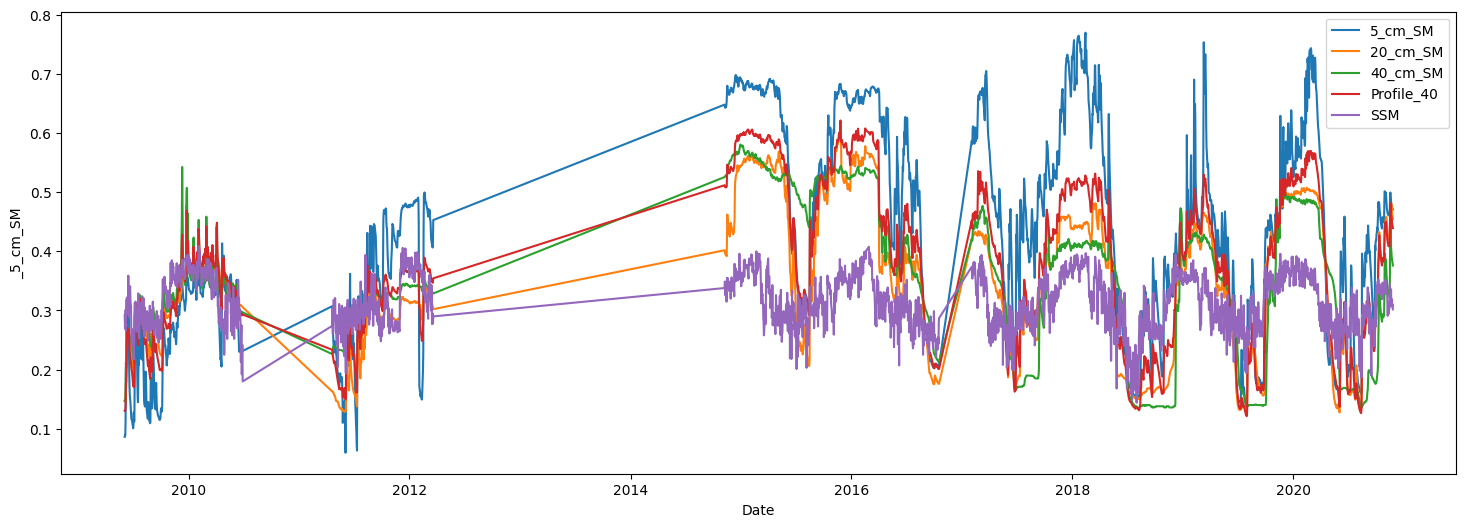

In [ ]:
plt.figure(figsize=(18, 6))
#sns.lineplot(x='Date', y='SSM', data=gssm)
sns.lineplot(x='Date', y='_5_cm_SM', data=clean_df, label='5_cm_SM')
sns.lineplot(x='Date', y='_20_cm_SM', data=clean_df,label='20_cm_SM')
sns.lineplot(x='Date', y='_40_cm_SM', data=clean_df,label='40_cm_SM')
sns.lineplot(x='Date', y='Profile_40', data=clean_df,label='Profile_40')
sns.lineplot(x='Date', y='SSM', data=clean_df, label='SSM')
plt.show

In [ ]:
percentile_975 = clean_df['_5_cm_SM'].quantile(0.975)
percentile_025 = clean_df['_5_cm_SM'].quantile(0.025)

print("95 percentile:", percentile_975)
print("5 percentile:", percentile_025)

95 percentile: 0.7142369791666666
5 percentile: 0.139828125


In [ ]:
wp=percentile_025
sp=percentile_975
clean_df['Scaled_SSM']= wp+(((clean_df['SSM']-clean_df['SSM'].min())*(sp-wp))/(clean_df['SSM'].max()-clean_df['SSM'].min()))
clean_df

Date    SSM  _5_cm_SM  _10_cm_SM  _20_cm_SM  _40_cm_SM  Profile_40  \
0    2009-06-04  0.292  0.086208   0.117677   0.146885   0.147146    0.130097   
1    2009-06-05  0.271  0.088469   0.117542   0.146521   0.147000    0.130322   
2    2009-06-06  0.269  0.088521   0.117531   0.146510   0.147000    0.130326   
3    2009-06-07  0.301  0.114771   0.119698   0.148510   0.155135    0.138438   
4    2009-06-08  0.266  0.211646   0.130354   0.164375   0.203229    0.176573   
...         ...    ...       ...        ...        ...        ...         ...   
2806 2020-11-21  0.313  0.476062   0.468687   0.479854   0.390646    0.454747   
2807 2020-11-22  0.319  0.476667   0.467375   0.467625   0.387802    0.449318   
2808 2020-11-23  0.307  0.473354   0.466250   0.461813   0.384323    0.445436   
2809 2020-11-24  0.310  0.472677   0.465052   0.459031   0.380635    0.443120   
2810 2020-11-25  0.302  0.470813   0.462646   0.454302   0.376083    0.439408   

      Scaled_SSM  
0       0.329751  
1       0.291475  
2       0.287830  
3       0.346155  
4       0.282362  
...          ...  
2806    0.368026  
2807    0.378962  
2808    0.357091  
2809    0.362558  
2810    0.347977  

[2811 rows x 8 columns]

<function matplotlib.pyplot.show(close=None, block=None)>

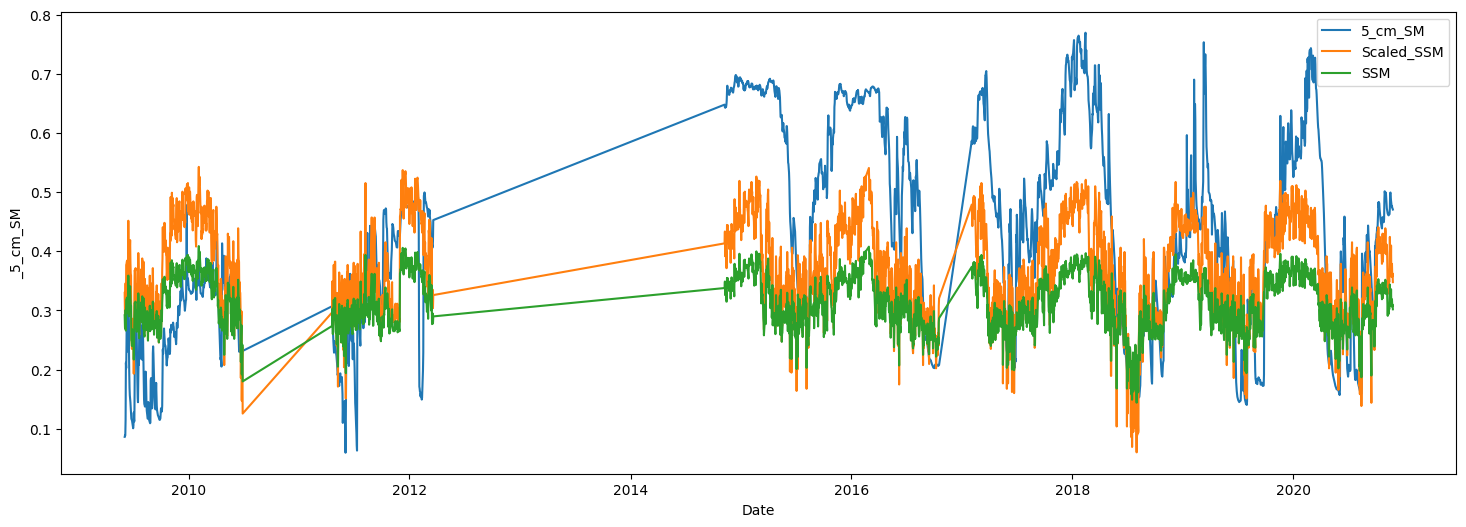

In [ ]:
plt.figure(figsize=(18, 6))
#sns.lineplot(x='Date', y='SSM', data=gssm)
sns.lineplot(x='Date', y='_5_cm_SM', data=clean_df, label='5_cm_SM')
sns.lineplot(x='Date', y='Scaled_SSM', data=clean_df,label='Scaled_SSM')
# sns.lineplot(x='Date', y='_40_cm_SM', data=clean_df,label='80_cm_SM')
# sns.lineplot(x='Date', y='Profile_40', data=clean_df,label='Profile_40')
sns.lineplot(x='Date', y='SSM', data=clean_df, label='SSM')
plt.show

In [ ]:
clean_df.columns

Index(['Date', 'SSM', '_5_cm_SM', '_10_cm_SM', '_20_cm_SM', '_40_cm_SM',
       'Profile_40', 'Scaled_SSM'],
      dtype='object')

In [ ]:
bias=np.mean(clean_df['SSM']-clean_df['_5_cm_SM'])

print(f'bias: {bias}')

bias: -0.11730888325625519


In [ ]:
rmse=np.sqrt(np.mean((clean_df['Scaled_SSM'] - clean_df['_5_cm_SM']) ** 2))
rmse

0.15477949017629458

In [ ]:
rmse=np.sqrt(np.mean((clean_df['SSM'] - clean_df['_5_cm_SM']) ** 2))
rmse

0.19078020812289753

In [ ]:
correlation=clean_df['Scaled_SSM'].corr(clean_df['_5_cm_SM'])
correlation

0.5715259561266902

In [ ]:
correlation=clean_df['SSM'].corr(clean_df['_5_cm_SM'])
correlation

0.5715259561266901

In [ ]:
correlation=clean_df['Profile_40'].corr(clean_df['_5_cm_SM'])
correlation

0.9361534514002959

# **4. Data Splitting**

In [ ]:
#First step =>
#Data splitting
# Define the calibration and validation years
complete_years = [2015,2016,2017,2018,2019,2020 ]
calibration_years = [2015,2016,2017,2018 ]
validation_years = [2019,2020]

# Create boolean masks for calibration and validation sets
complete_mask = clean_df['Date'].dt.year.isin(complete_years)
calibration_mask = clean_df['Date'].dt.year.isin(calibration_years)
validation_mask = clean_df['Date'].dt.year.isin(validation_years)

# Separate data into calibration and validation sets
com_data = clean_df[complete_mask]
cal_data = clean_df[calibration_mask]
val_data = clean_df[validation_mask]

# Optional: Reset index if needed
com_data.reset_index(drop=True, inplace=True)
cal_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
com_data

Date    SSM  _5_cm_SM  _10_cm_SM  _20_cm_SM  _40_cm_SM  Profile_40  \
0    2015-01-01  0.359  0.691875   0.634687   0.544000   0.579125    0.597512   
1    2015-01-02  0.341  0.688458   0.633510   0.546125   0.578417    0.597270   
2    2015-01-03  0.362  0.687708   0.632979   0.545573   0.577313    0.596547   
3    2015-01-04  0.364  0.689187   0.634042   0.545979   0.578292    0.597421   
4    2015-01-05  0.350  0.688604   0.635833   0.547125   0.579250    0.598316   
...         ...    ...       ...        ...        ...        ...         ...   
2027 2020-11-21  0.313  0.476062   0.468687   0.479854   0.390646    0.454747   
2028 2020-11-22  0.319  0.476667   0.467375   0.467625   0.387802    0.449318   
2029 2020-11-23  0.307  0.473354   0.466250   0.461813   0.384323    0.445436   
2030 2020-11-24  0.310  0.472677   0.465052   0.459031   0.380635    0.443120   
2031 2020-11-25  0.302  0.470813   0.462646   0.454302   0.376083    0.439408   

      Scaled_SSM  
0       0.451868  
1       0.419060  
2       0.457336  
3       0.460981  
4       0.435464  
...          ...  
2027    0.368026  
2028    0.378962  
2029    0.357091  
2030    0.362558  
2031    0.347977  

[2032 rows x 8 columns]

In [ ]:
# Sorting the columns in ascending order and resetting index
ssm = com_data['SSM'].sort_values(ascending=True).reset_index(drop=True)
s10cm = com_data['_10_cm_SM'].sort_values(ascending=True).reset_index(drop=True)
s20 = com_data['_20_cm_SM'].sort_values(ascending=True).reset_index(drop=True)
s40 = com_data['_40_cm_SM'].sort_values(ascending=True).reset_index(drop=True)

# Calculating differences
dif10 = ssm - s10cm
dif20 = ssm - s20
dif40 = ssm - s40

# Create a DataFrame with the specified columns
clean_df3 = pd.DataFrame({
    'SSM': ssm,
    's10cm': s10cm,
    'dif10': dif10,
    's20cm': s20,
    'dif20': dif20,
    's40cm': s40,
    'dif40': dif40
})
clean_df3.head()

SSM     s10cm     dif10     s20cm     dif20     s40cm     dif40
0  0.144  0.067187  0.076812  0.126438  0.017562  0.134000  0.010000
1  0.149  0.067292  0.081708  0.127417  0.021583  0.134521  0.014479
2  0.158  0.070135  0.087865  0.127479  0.030521  0.134750  0.023250
3  0.160  0.070250  0.089750  0.128688  0.031312  0.135021  0.024979
4  0.162  0.070646  0.091354  0.129083  0.032917  0.135458  0.026542

In [ ]:
clean=com_data[['Profile_40','SSM']]
# clean2=com_data[['Date','SSM','Profile_40']]

In [ ]:
# clean.to_csv('/content/drive/MyDrive/Tafiti/Post_Midterm/Objective_1/Clean_df/ITC_SM12.csv')
# clean_df3.to_csv('/content/drive/MyDrive/Tafiti/Post_Midterm/Objective_1/Clean_df3/ITC_SM02.csv')

<function matplotlib.pyplot.show(close=None, block=None)>

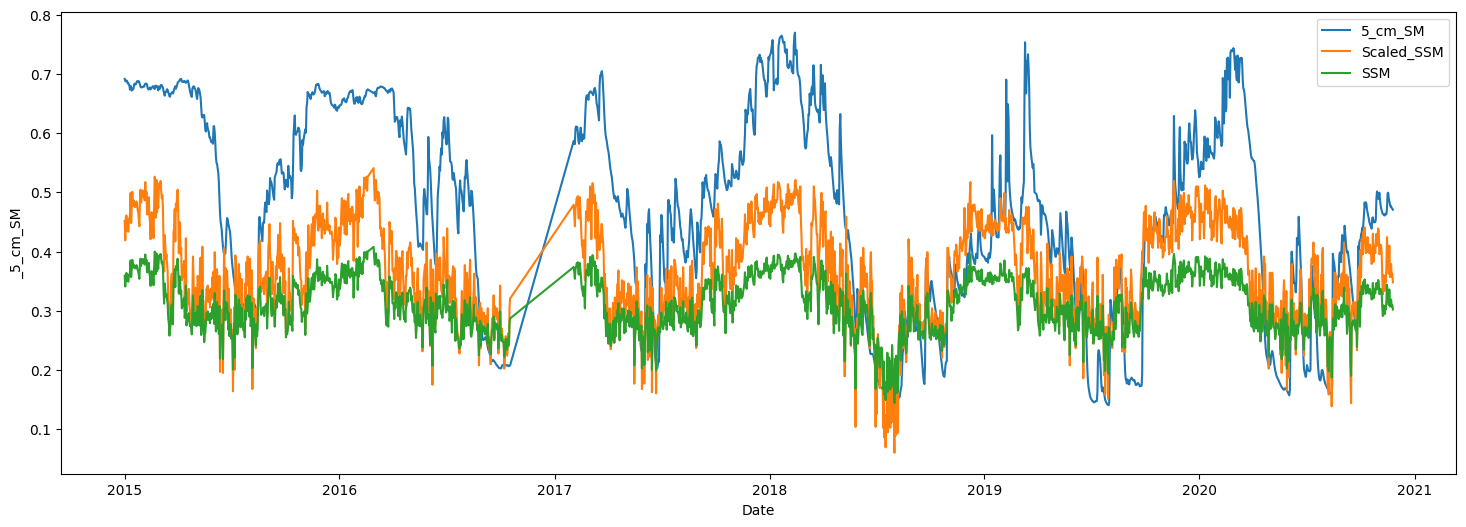

In [ ]:
plt.figure(figsize=(18, 6))
#sns.lineplot(x='Date', y='SSM', data=gssm)
sns.lineplot(x='Date', y='_5_cm_SM', data=com_data, label='5_cm_SM')
sns.lineplot(x='Date', y='Scaled_SSM', data=com_data,label='Scaled_SSM')
# sns.lineplot(x='Date', y='_40_cm_SM', data=clean_df,label='80_cm_SM')
# sns.lineplot(x='Date', y='Profile_40', data=clean_df,label='Profile_40')
sns.lineplot(x='Date', y='SSM', data=com_data, label='SSM')
plt.show

# **5. ELPF Implementation**

In [ ]:
def calculate_Kn_rzsm(df, T):
    """
    Calculate Kn and rzsm values for a DataFrame based on the provided formulas.

    Parameters:
    - df: DataFrame with 'sm' and 'date' columns.
    - T: Parameter T in the formula.

    Returns:
    - DataFrame with additional 'Kn' and 'rzsm' columns.
    """
    # Make sure 'date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    # Sort DataFrame by date
    df = df.sort_values(by='Date').reset_index(drop=True)


    # Initialize the 'Kn' column with 1 for the first row
    df['Kn'] = 1

    # Initialize the 'rzsm' column with the 'sm' values for the first row
    df['rzsm'] = df['SSM']

    # Calculate Kn and rzsm for each row
    for i in range(1, len(df)):
        df.at[i, 'Kn'] = df.at[i-1, 'Kn'] / (df.at[i-1, 'Kn'] + np.exp(-((df.at[i, 'Date'] - df.at[i-1, 'Date']).days / T)))
        df.at[i, 'rzsm'] = df.at[i-1, 'rzsm'] + (df.at[i, 'Kn'] * (df.at[i, 'SSM'] - df.at[i-1, 'rzsm']))

    return df

In [ ]:
# Define a list of T values
T_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Create an empty DataFrame to store the results
result_df1 = pd.DataFrame()

# Iterate through T values
for T in T_values:
    # Make a copy of the original DataFrame to avoid modifying it
    current_df = cal_data.copy()

    # Apply the calculate_Kn_rzsm function for the current T value
    current_df = calculate_Kn_rzsm(current_df, T)

    # Extract the relevant columns for the result DataFrame
    result_columns = ['Date', 'SSM', 'Kn', 'rzsm', '_5_cm_SM', '_10_cm_SM', '_20_cm_SM','_40_cm_SM','Profile_40','Scaled_SSM']

    # Create a new DataFrame with the results for the current T value
    result_for_T = current_df[result_columns]

    # Rename the 'rzsm' column to include the T value
    result_for_T = result_for_T.rename(columns={'rzsm': f'rzsm_{T}'})

    # Concatenate the result DataFrame for the current T value to the overall result_df
    result_df1 = pd.concat([result_df1, result_for_T], axis=1)

In [ ]:
#Remove duplicate columns from the results
result_df1 = result_df1.loc[:, ~result_df1.columns.duplicated()]
# Create a new DataFrame with only the selected columns
correlation_df = result_df1.drop(['Kn', 'Date'], axis=1)

# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()

In [ ]:
# List of indices to drop
indices_to_drop = ['SSM', '_5_cm_SM', '_10_cm_SM', '_20_cm_SM', '_40_cm_SM','Profile_40','Scaled_SSM']

# Drop the rows with the specified indices
correlation_matrix.drop(indices_to_drop, inplace=True)

top_5_matches = correlation_matrix.nlargest(5, 'Profile_40')

top_5_matches

SSM   rzsm_10  _5_cm_SM  _10_cm_SM  _20_cm_SM  _40_cm_SM  \
rzsm_40  0.711207  0.900893  0.859515   0.821052   0.811191   0.727195   
rzsm_30  0.760814  0.944218  0.866388   0.829917   0.810592   0.709004   
rzsm_50  0.663870  0.855792  0.844204   0.806412   0.804440   0.736569   
rzsm_20  0.811348  0.980588  0.859710   0.829790   0.796891   0.677738   
rzsm_60  0.620389  0.812115  0.824295   0.788604   0.793933   0.740228   

         Profile_40  Scaled_SSM   rzsm_20   rzsm_30   rzsm_40   rzsm_50  \
rzsm_40    0.844807    0.711207  0.963446  0.992022  1.000000  0.994182   
rzsm_30    0.843562    0.760814  0.989078  1.000000  0.992022  0.973028   
rzsm_50    0.838066    0.663870  0.930909  0.973028  0.994182  1.000000   
rzsm_20    0.829357    0.811348  1.000000  0.989078  0.963446  0.930909   
rzsm_60    0.826834    0.620389  0.896185  0.948542  0.980174  0.995735   

          rzsm_60   rzsm_70   rzsm_80   rzsm_90  rzsm_100  
rzsm_40  0.980174  0.961813  0.941510  0.920712  0.900254  
rzsm_30  0.948542  0.921970  0.895269  0.869492  0.845161  
rzsm_50  0.995735  0.985336  0.971468  0.955849  0.939558  
rzsm_20  0.896185  0.861911  0.829436  0.799344  0.771801  
rzsm_60  1.000000  0.996833  0.989004  0.978390  0.966239

In [ ]:
# Define a list of T values
T_values = list(range(1, 70))

# Create an empty DataFrame to store the results
result_df1 = pd.DataFrame()

# Iterate through T values
for T in T_values:
    # Make a copy of the original DataFrame to avoid modifying it
    current_df = cal_data.copy()

    # Apply the calculate_Kn_rzsm function for the current T value
    current_df = calculate_Kn_rzsm(current_df, T)

    # Extract the relevant columns for the result DataFrame
    result_columns = ['Date', 'SSM', 'Kn', 'rzsm', '_5_cm_SM', '_10_cm_SM', '_20_cm_SM','_40_cm_SM','Profile_40','Scaled_SSM']

    # Create a new DataFrame with the results for the current T value
    result_for_T = current_df[result_columns]

    # Rename the 'rzsm' column to include the T value
    result_for_T = result_for_T.rename(columns={'rzsm': f'rzsm_{T}'})

    # Concatenate the result DataFrame for the current T value to the overall result_df
    result_df1 = pd.concat([result_df1, result_for_T], axis=1)

In [ ]:
#Remove duplicate columns from the results
result_df1 = result_df1.loc[:, ~result_df1.columns.duplicated()]
# Create a new DataFrame with only the selected columns
correlation_df = result_df1.drop(['Kn', 'Date'], axis=1)

# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()

In [ ]:
# List of indices to drop
indices_to_drop = ['SSM', '_5_cm_SM', '_10_cm_SM', '_20_cm_SM', '_40_cm_SM','Profile_40','Scaled_SSM']

# Drop the rows with the specified indices
correlation_matrix.drop(indices_to_drop, inplace=True)

top_5_matches = correlation_matrix.nlargest(5, '_40_cm_SM')

top_5_matches

SSM    rzsm_1  _5_cm_SM  _10_cm_SM  _20_cm_SM  _40_cm_SM  \
rzsm_65  0.600342  0.634069  0.813466   0.779149   0.787971   0.740612   
rzsm_66  0.596473  0.630031  0.811262   0.777239   0.786747   0.740600   
rzsm_64  0.604258  0.638155  0.815659   0.781054   0.789187   0.740596   
rzsm_67  0.592650  0.626042  0.809050   0.775327   0.785515   0.740562   
rzsm_63  0.608221  0.642289  0.817840   0.782954   0.790392   0.740551   

         Profile_40  Scaled_SSM    rzsm_2    rzsm_3  ...   rzsm_60   rzsm_61  \
rzsm_65    0.820289    0.600342  0.663852  0.686723  ...  0.999148  0.999463   
rzsm_66    0.818934    0.596473  0.659714  0.682539  ...  0.998792  0.999173   
rzsm_64    0.821631    0.604258  0.668039  0.690955  ...  0.999447  0.999693   
rzsm_67    0.817567    0.592650  0.655625  0.678403  ...  0.998379  0.998826   
rzsm_63    0.822958    0.608221  0.672274  0.695235  ...  0.999684  0.999862   

          rzsm_62   rzsm_63   rzsm_64   rzsm_65   rzsm_66   rzsm_67   rzsm_68  \
rzsm_65  0.999702  0.999870  0.999968  1.000000  0.999969  0.999877  0.999727   
rzsm_66  0.999478  0.999711  0.999873  0.999969  1.000000  0.999970  0.999880   
rzsm_64  0.999866  0.999967  1.000000  0.999968  0.999873  0.999719  0.999508   
rzsm_67  0.999197  0.999493  0.999719  0.999877  0.999970  1.000000  0.999971   
rzsm_63  0.999966  1.000000  0.999967  0.999870  0.999711  0.999493  0.999220   

          rzsm_69  
rzsm_65  0.999522  
rzsm_66  0.999735  
rzsm_64  0.999242  
rzsm_67  0.999884  
rzsm_63  0.998893  

[5 rows x 76 columns]

In [ ]:
top_5_matches = correlation_matrix.nlargest(2, '_20_cm_SM')

top_5_matches

SSM    rzsm_1  _5_cm_SM  _10_cm_SM  _20_cm_SM  _40_cm_SM  \
rzsm_35  0.735855  0.775319  0.864303   0.826392   0.812115   0.719441   
rzsm_36  0.730892  0.770147  0.863541   0.825456   0.812103   0.721189   

         Profile_40  Scaled_SSM    rzsm_2    rzsm_3  ...   rzsm_60   rzsm_61  \
rzsm_35    0.845459    0.735855  0.808015  0.831611  ...  0.966678  0.964531   
rzsm_36    0.845512    0.730892  0.802758  0.826365  ...  0.969729  0.967674   

          rzsm_62   rzsm_63   rzsm_64   rzsm_65   rzsm_66   rzsm_67   rzsm_68  \
rzsm_35  0.962355  0.960154  0.957928  0.955681  0.953415  0.951132  0.948833   
rzsm_36  0.965588  0.963474  0.961334  0.959170  0.956985  0.954781  0.952560   

          rzsm_69  
rzsm_35  0.946521  
rzsm_36  0.950324  

[2 rows x 76 columns]

In [ ]:
top_5_matches = correlation_matrix.nlargest(2, 'Profile_40')

top_5_matches

SSM    rzsm_1  _5_cm_SM  _10_cm_SM  _20_cm_SM  _40_cm_SM  \
rzsm_36  0.730892  0.770147  0.863541   0.825456   0.812103   0.721189   
rzsm_37  0.725944  0.764990  0.862676   0.824452   0.811999   0.722835   

         Profile_40  Scaled_SSM    rzsm_2    rzsm_3  ...   rzsm_60   rzsm_61  \
rzsm_36    0.845512    0.730892  0.802758  0.826365  ...  0.969729  0.967674   
rzsm_37    0.845469    0.725944  0.797514  0.821129  ...  0.972599  0.970636   

          rzsm_62   rzsm_63   rzsm_64   rzsm_65   rzsm_66   rzsm_67   rzsm_68  \
rzsm_36  0.965588  0.963474  0.961334  0.959170  0.956985  0.954781  0.952560   
rzsm_37  0.968639  0.966613  0.964558  0.962478  0.960374  0.958250  0.956106   

          rzsm_69  
rzsm_36  0.950324  
rzsm_37  0.953945  

[2 rows x 76 columns]

In [ ]:
# Define a list of T values
T_values = [2]

# Create an empty DataFrame to store the results
result_df = pd.DataFrame()

# Iterate through T values
for T in T_values:
    # Make a copy of the original DataFrame to avoid modifying it
    current_df = val_data.copy()

    # Apply the calculate_Kn_rzsm function for the current T value
    current_df = calculate_Kn_rzsm(current_df, T)

    # Extract the relevant columns for the result DataFrame
    result_columns = ['Date','Scaled_SSM', 'SSM', 'Kn', 'rzsm', '_5_cm_SM', '_10_cm_SM', '_20_cm_SM','_40_cm_SM','Profile_40']

    # Create a new DataFrame with the results for the current T value
    result_for_T = current_df[result_columns]

    # Rename the 'rzsm' column to include the T value
    result_for_T = result_for_T.rename(columns={'rzsm': f'rzsm_p'})

    # Concatenate the result DataFrame for the current T value to the overall result_df
    result_df = pd.concat([result_df, result_for_T], axis=1)

In [ ]:
x=result_df['Profile_40']
y=result_df['rzsm_p']
n=len(x)
# Calculate unRMSE
sum_squared_diff = np.sum((y - x) ** 2)
unrmse = (1 / n) * np.sqrt(n * sum_squared_diff - sum_squared_diff)

print(f"unRMSE: {unrmse}")

unRMSE: 0.11274609850759697


In [ ]:
correlation=result_df['rzsm_p'].corr(result_df['Profile_40'])
print("Correlation btn 1Km SSM and Insitu 5cm SM is:", correlation)

rmse=np.sqrt(np.mean((result_df['Profile_40'] - result_df['rzsm_p']) ** 2))
rmse

Correlation btn 1Km SSM and Insitu 5cm SM is: 0.827699738923078


0.11282729844502759

In [ ]:
bias=np.mean(result_df['rzsm_p']-result_df['Profile_40'])

print(f'bias: {bias}')

bias: -0.045513726852754004


In [ ]:
sp5 = com_data['_5_cm_SM'].quantile(0.975)
wp5 = com_data['_5_cm_SM'].quantile(0.025)

print("95 percentile:", sp5)
print("5 percentile:", wp5)

95 percentile: 0.7242549479166666
5 percentile: 0.16131536458333334


In [ ]:
sp10 = com_data['_10_cm_SM'].quantile(0.975)
wp10 = com_data['_10_cm_SM'].quantile(0.025)

print("95 percentile:", sp10)
print("5 percentile:", wp10)

95 percentile: 0.6849687499999999
5 percentile: 0.08225338541666667


In [ ]:
sp20 = com_data['_20_cm_SM'].quantile(0.975)
wp20 = com_data['_20_cm_SM'].quantile(0.025)

print("95 percentile:", sp20)
print("5 percentile:", wp20)

95 percentile: 0.5613856770833333
5 percentile: 0.14027630208333336


In [ ]:
sp40 = com_data['Profile_40'].quantile(0.975)
wp40 = com_data['Profile_40'].quantile(0.025)

print("95 percentile:", sp40)
print("5 percentile:", wp40)

95 percentile: 0.5990684733072917
5 percentile: 0.13817807617187497


In [ ]:
# Define a list of T values for each rzsm column
T_values = {'rzsm_10': 16, 'rzsm_20':17, 'rzsm_40': 30}

# Create an empty DataFrame to store the results
result_df = pd.DataFrame()

# Iterate through rzsm columns and their corresponding T values
for rzsm_column, T in T_values.items():
    # Make a copy of the original DataFrame to avoid modifying it
    current_df = val_data.copy()

    # Apply the calculate_Kn_rzsm function for the current T value
    current_df = calculate_Kn_rzsm(current_df, T)

    # Extract the relevant columns for the result DataFrame
    result_columns = ['Date', 'Scaled_SSM', 'SSM', 'Kn', 'rzsm', '_5_cm_SM', '_10_cm_SM', '_20_cm_SM', '_40_cm_SM', 'Profile_40']

    # Create a new DataFrame with the results for the current T value
    result_for_T = current_df[result_columns]

    # Rename the 'rzsm' column to include the T value
    result_for_T = result_for_T.rename(columns={'rzsm': rzsm_column})

    # Concatenate the result DataFrame for the current T value to the overall result_df
    result_df = pd.concat([result_df, result_for_T[rzsm_column]], axis=1)

# Add 'Date' and 'Profile_40' columns to the result DataFrame
result_df['Date'] = current_df['Date']
result_df['Profile_40'] = current_df['Profile_40']
result_df['SSM'] = current_df['SSM']

result_df.head()


rzsm_10   rzsm_20   rzsm_40       Date  Profile_40    SSM
0  0.343000  0.343000  0.343000 2019-01-01    0.392776  0.343
1  0.343000  0.343000  0.343000 2019-01-02    0.390535  0.343
2  0.346898  0.346884  0.346790 2019-01-03    0.387844  0.354
3  0.349117  0.349096  0.348946 2019-01-04    0.385505  0.355
4  0.349316  0.349298  0.349171 2019-01-05    0.385683  0.350

In [ ]:
# result_df['SSM']= wp10+(((result_df['SSM']-result_df['SSM'].min())*(sp10-wp10))/(result_df['SSM'].max()-result_df['SSM'].min()))
result_df['rzsm_10']= wp10+(((result_df['rzsm_10']-result_df['rzsm_10'].min())*(sp10-wp10))/(result_df['rzsm_10'].max()-result_df['rzsm_10'].min()))
result_df['rzsm_20']= wp20+(((result_df['rzsm_20']-result_df['rzsm_20'].min())*(sp20-wp20))/(result_df['rzsm_20'].max()-result_df['rzsm_20'].min()))
result_df['rzsm_40']= wp40+(((result_df['rzsm_40']-result_df['rzsm_40'].min())*(sp40-wp40))/(result_df['rzsm_40'].max()-result_df['rzsm_40'].min()))

In [ ]:
dmnator=2*(5+5+10+20)
result_df['rzsm_prd']=((2*5*result_df['SSM'])+((result_df['SSM']+result_df['rzsm_10'])*5)+((result_df['rzsm_10']+result_df['rzsm_20'])*10)+((result_df['rzsm_20']+result_df['rzsm_40'])*20))/dmnator

In [ ]:
rmse=np.sqrt(np.mean((result_df['Profile_40'] - result_df['rzsm_prd']) ** 2))
rmse

0.05461882297853366

In [ ]:
correlation=result_df['rzsm_prd'].corr(result_df['Profile_40'])
print("Correlation btn 1Km SSM and Insitu 5cm SM is:", correlation)

Correlation btn 1Km SSM and Insitu 5cm SM is: 0.9165966509198148


In [ ]:
bias=np.mean(result_df['rzsm_prd']-result_df['Profile_40'])

print(f'bias: {bias}')

bias: -0.010962589723344287


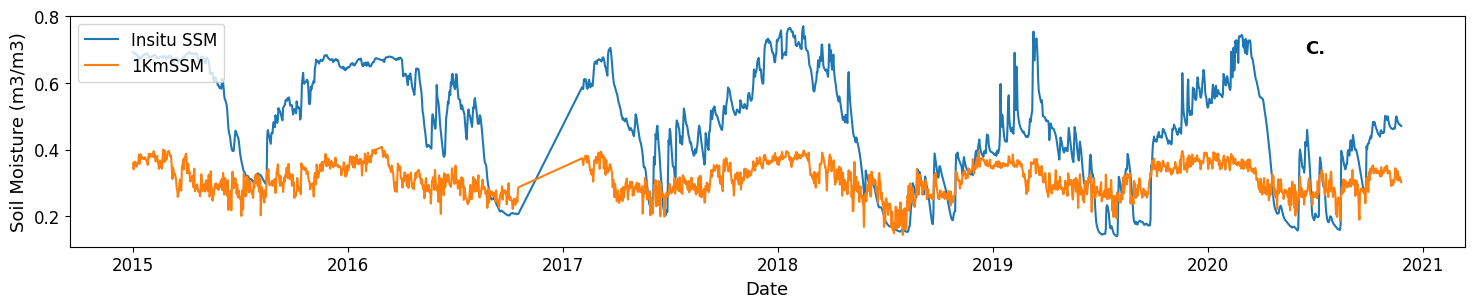

In [ ]:
plt.figure(figsize=(18, 3))
plt.plot(com_data['Date'],com_data['_5_cm_SM'],label="Insitu SSM")
plt.plot(com_data['Date'],com_data['SSM'],label="1KmSSM")


# Set labels and title
plt.xlabel('Date', fontsize=13)
plt.ylabel('Soil Moisture (m3/m3)', fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.legend(prop = { "size": 12 },loc='upper left')

# Remove grid
plt.grid(False)

# Add label inside plot
plt.text(0.9, 0.9, 'C.', fontsize=13, weight='bold', ha='right', va='top', transform=plt.gca().transAxes)

plt.show()

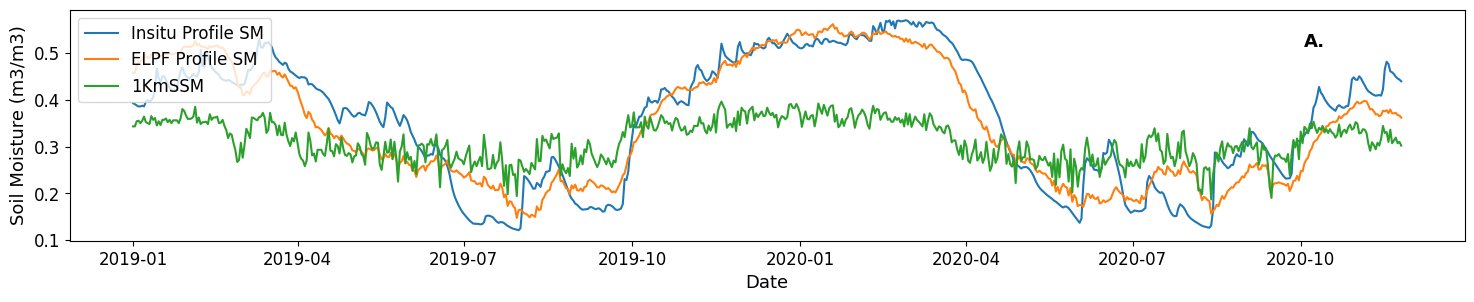

In [ ]:
plt.figure(figsize=(18, 3))
plt.plot(result_df['Date'], result_df['Profile_40'], label="Insitu Profile SM")
plt.plot(result_df['Date'], result_df['rzsm_prd'], label="ELPF Profile SM")
plt.plot(result_df['Date'], result_df['SSM'], label="1KmSSM")



# Set labels and title
plt.xlabel('Date', fontsize=13)
plt.ylabel('Soil Moisture (m3/m3)', fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.legend(prop = { "size": 12 },loc='upper left')

# Remove grid
plt.grid(False)

# Add label inside plot
plt.text(0.9, 0.9, 'A.', fontsize=13, weight='bold', ha='right', va='top', transform=plt.gca().transAxes)

plt.show()

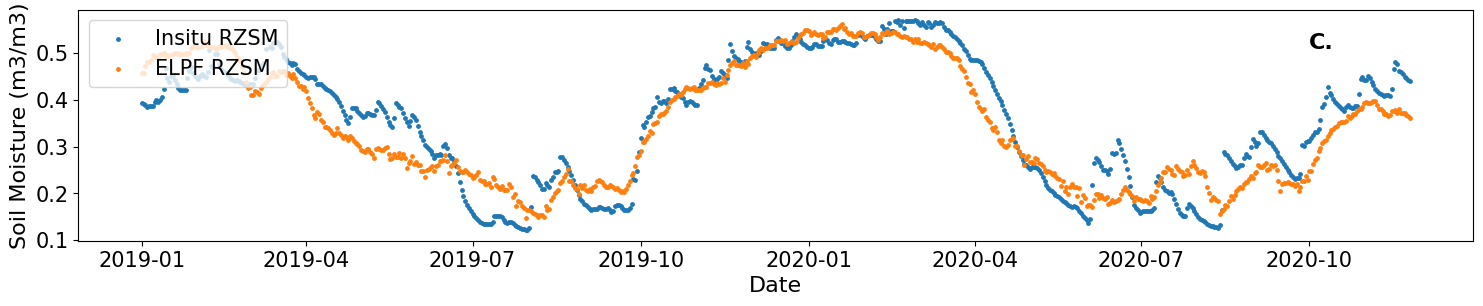

In [ ]:
plt.figure(figsize=(18, 3))
plt.scatter(result_df['Date'], result_df['Profile_40'], label="Insitu RZSM", s=6)
plt.scatter(result_df['Date'], result_df['rzsm_prd'], label="ELPF RZSM", s=6)


# Set labels and title
plt.xlabel('Date', fontsize=16)
plt.ylabel('Soil Moisture (m3/m3)', fontsize=16)


plt.legend(prop = { "size": 15 },loc='upper left')
plt.tick_params(axis='both', which='major', labelsize=15)

# Remove grid
plt.grid(False)

# Add label inside plot
plt.text(0.9, 0.9, 'C.', fontsize=16, weight='bold', ha='right', va='top', transform=plt.gca().transAxes)

plt.show()

In [ ]:
correlation=result_df['rzsm_prd'].corr(result_df['Profile_40'])
print("Correlation btn 1Km SSM and Insitu 5cm SM is:", correlation)

rmse=np.sqrt(np.mean((result_df['Profile_40'] - result_df['rzsm_prd']) ** 2))
rmse

Correlation btn 1Km SSM and Insitu 5cm SM is: 0.9165966509198148


0.05461882297853366

In [ ]:
bias=np.mean(result_df['rzsm_prd']-result_df['Profile_40'])

print(f'bias: {bias}')

bias: -0.010962589723344287


In [ ]:
# Define a list of T values for each rzsm column
T_values = {'elpf_10': 16, 'elpf_20':17, 'elpf_40': 30}

# Create an empty DataFrame to store the results
result_df = pd.DataFrame()

# Iterate through rzsm columns and their corresponding T values
for rzsm_column, T in T_values.items():
    # Make a copy of the original DataFrame to avoid modifying it
    current_df = cal_data.copy()

    # Apply the calculate_Kn_rzsm function for the current T value
    current_df = calculate_Kn_rzsm(current_df, T)

    # Extract the relevant columns for the result DataFrame
    result_columns = ['Date', 'Scaled_SSM', 'SSM', 'Kn', 'rzsm', '_5_cm_SM', '_10_cm_SM', '_20_cm_SM', '_40_cm_SM', 'Profile_40']

    # Create a new DataFrame with the results for the current T value
    result_for_T = current_df[result_columns]

    # Rename the 'rzsm' column to include the T value
    result_for_T = result_for_T.rename(columns={'rzsm': rzsm_column})

    # Concatenate the result DataFrame for the current T value to the overall result_df
    result_df = pd.concat([result_df, result_for_T[rzsm_column]], axis=1)

# Add 'Date' and 'Profile_40' columns to the result DataFrame
result_df['Date'] = current_df['Date']
result_df['Profile_40'] = current_df['Profile_40']
result_df['SSM'] = current_df['SSM']
result_df['_10_cm_SM'] = current_df['_10_cm_SM']
result_df['_20_cm_SM'] = current_df['_20_cm_SM']
result_df['_40_cm_SM'] = current_df['_40_cm_SM']

result_df.head()


elpf_10   elpf_20   elpf_40       Date  Profile_40    SSM  _10_cm_SM  \
0  0.359000  0.359000  0.359000 2015-01-01    0.597512  0.359   0.634687   
1  0.349719  0.349735  0.349850 2015-01-02    0.597270  0.341   0.633510   
2  0.354071  0.354066  0.354036 2015-01-03    0.596547  0.362   0.632979   
3  0.356791  0.356773  0.356653 2015-01-04    0.597421  0.364   0.634042   
4  0.355258  0.355254  0.355232 2015-01-05    0.598316  0.350   0.635833   

   _20_cm_SM  _40_cm_SM  
0   0.544000   0.579125  
1   0.546125   0.578417  
2   0.545573   0.577313  
3   0.545979   0.578292  
4   0.547125   0.579250

In [ ]:
# Sorting the columns in ascending order and resetting index
ssm = result_df['SSM'].sort_values(ascending=True).reset_index(drop=True)
elpf_10cm = result_df['elpf_10'].sort_values(ascending=True).reset_index(drop=True)
elpf_20 = result_df['elpf_20'].sort_values(ascending=True).reset_index(drop=True)
elpf_40 = result_df['elpf_40'].sort_values(ascending=True).reset_index(drop=True)
s10cm = result_df['_10_cm_SM'].sort_values(ascending=True).reset_index(drop=True)
s20 = result_df['_20_cm_SM'].sort_values(ascending=True).reset_index(drop=True)
s40 = result_df['_40_cm_SM'].sort_values(ascending=True).reset_index(drop=True)

# Calculating differences
dif10 = elpf_10cm - s10cm
dif20 = elpf_20 - s20
dif40 = elpf_40 - s40

# Create a DataFrame with the specified columns
clean_df3 = pd.DataFrame({
    'SSM': ssm,
    'elpf_10': elpf_10cm,
    'dif10': dif10,
    'elpf_20': elpf_20,
    'dif20': dif20,
    'elpf_40': elpf_40,
    'dif40': dif40
})
clean_df3.head()

SSM   elpf_10     dif10   elpf_20     dif20   elpf_40     dif40
0  0.144  0.198893  0.131705  0.200486  0.050486  0.219528  0.085528
1  0.149  0.201143  0.133852  0.202696  0.052696  0.220199  0.085679
2  0.158  0.201384  0.131248  0.202743  0.052743  0.221411  0.086661
3  0.160  0.203668  0.132366  0.205162  0.054683  0.221570  0.086549
4  0.162  0.204325  0.132919  0.205959  0.055334  0.222568  0.087089

In [ ]:
gssm.head()

Date    SSM
0  05-03-2000  0.387
1  06-03-2000  0.352
2  07-03-2000  0.346
3  08-03-2000  0.348
4  09-03-2000  0.355

In [ ]:
# Define the calibration and validation years
complete_years = [2015,2016,2017,2018,2019,2020 ]
gssm['Date'] = pd.to_datetime(gssm['Date'], format='%d-%m-%Y')
# Create boolean masks for calibration and validation sets
complete_mask = gssm['Date'].dt.year.isin(complete_years)

com_gssm = gssm[complete_mask]

# Optional: Reset index if needed
com_gssm.reset_index(drop=True, inplace=True)
com_gssm.head()

Date    SSM
0 2015-01-01  0.359
1 2015-01-02  0.341
2 2015-01-03  0.362
3 2015-01-04  0.364
4 2015-01-05  0.350

# **6. Anomalies Analysis**

In [ ]:
# Define a list of T values for each rzsm column
T_values = {'rzsm_10': 16, 'rzsm_20':17, 'rzsm_40': 30}

# Create an empty DataFrame to store the results
result_df = pd.DataFrame()

# Iterate through rzsm columns and their corresponding T values
for rzsm_column, T in T_values.items():
    # Make a copy of the original DataFrame to avoid modifying it
    current_df = com_gssm.copy()

    # Apply the calculate_Kn_rzsm function for the current T value
    current_df = calculate_Kn_rzsm(current_df, T)

    # Extract the relevant columns for the result DataFrame
    result_columns = ['Date', 'SSM', 'Kn', 'rzsm']

    # Create a new DataFrame with the results for the current T value
    result_for_T = current_df[result_columns]

    # Rename the 'rzsm' column to include the T value
    result_for_T = result_for_T.rename(columns={'rzsm': rzsm_column})

    # Concatenate the result DataFrame for the current T value to the overall result_df
    result_df = pd.concat([result_df, result_for_T[rzsm_column]], axis=1)

# Add 'Date' and 'Profile_40' columns to the result DataFrame
result_df['Date'] = current_df['Date']
result_df['SSM'] = current_df['SSM']


dmnator=2*(5+5+10+20)
result_df['rzsm_prd']=((2*5*result_df['SSM'])+((result_df['SSM']+result_df['rzsm_10'])*5)+((result_df['rzsm_10']+result_df['rzsm_20'])*10)+((result_df['rzsm_20']+result_df['rzsm_40'])*20))/dmnator
result_df.head()

rzsm_10   rzsm_20   rzsm_40       Date    SSM  rzsm_prd
0  0.359000  0.359000  0.359000 2015-01-01  0.359  0.359000
1  0.349719  0.349735  0.349850 2015-01-02  0.341  0.348123
2  0.354071  0.354066  0.354036 2015-01-03  0.362  0.355547
3  0.356791  0.356773  0.356653 2015-01-04  0.364  0.358101
4  0.355258  0.355254  0.355232 2015-01-05  0.350  0.354264

In [ ]:
# Calculate Soil Moisture Anomalies
mean_insitu = com_data['Profile_40'].mean()
std_insitu = com_data['Profile_40'].std()
com_data['Insitu_Anomaly'] = (com_data['Profile_40'] - mean_insitu) / std_insitu

mean_pred = result_df['rzsm_prd'].mean()
std_pred = result_df['rzsm_prd'].std()
result_df['Prd_Anomaly'] = (result_df['rzsm_prd'] - mean_pred) / std_pred

In [ ]:
print("mean_insitu:", mean_insitu)
print("std_insitu:", std_insitu)


print("mean_pred:", mean_pred)
print("std_pred:", std_pred)

mean_insitu: 0.395592811564448
std_insitu: 0.13983839775024992
mean_pred: 0.31412921205295735
std_pred: 0.03699310891318479


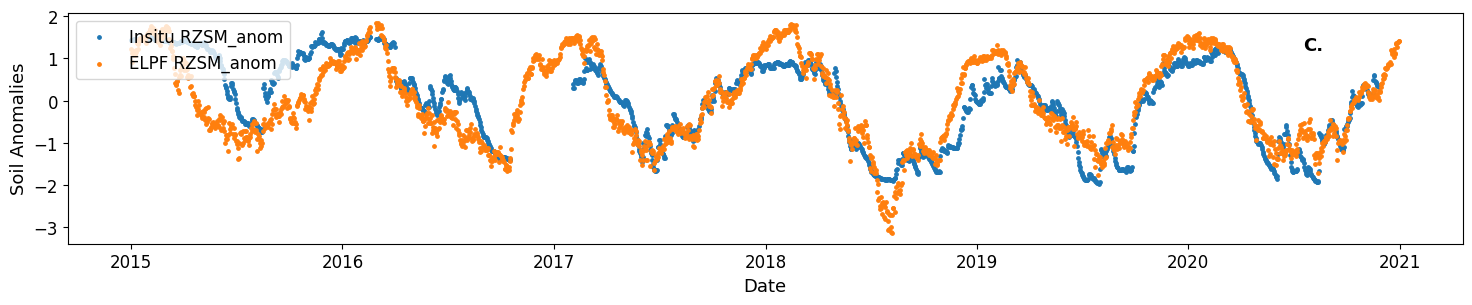

In [ ]:
plt.figure(figsize=(18, 3))
# plt.plot(com_data['Date'], com_data['Insitu_Anomaly'], label="Insitu SM Anomalies", marker='o', markersize=3, markerfacecolor='none')
plt.scatter(com_data['Date'], com_data['Insitu_Anomaly'], label="Insitu RZSM_anom", s=6)
#plt.plot(result_df['Date'], result_df['Prd_Anomaly'], label="ELPF SM Anomalies", marker='o', markersize=3, markerfacecolor='none')
plt.scatter(result_df['Date'], result_df['Prd_Anomaly'], label="ELPF RZSM_anom", s=6)


# Set labels and title
plt.xlabel('Date', fontsize=13)
plt.ylabel('Soil Anomalies', fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.legend(prop = { "size": 12 },loc='upper left')

# Remove grid
plt.grid(False)

# Add label inside plot
plt.text(0.9, 0.9, 'C.', fontsize=13, weight='bold', ha='right', va='top', transform=plt.gca().transAxes)

plt.show()

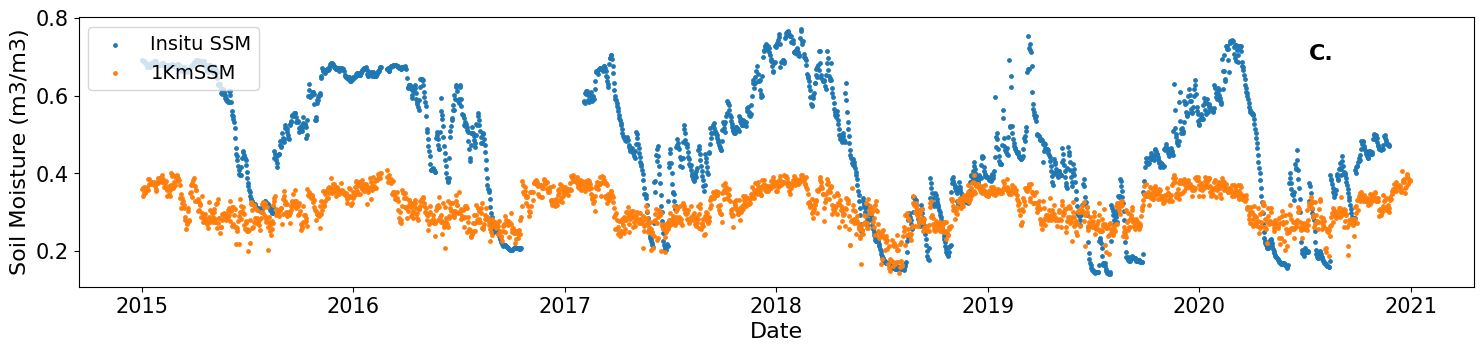

In [ ]:
plt.figure(figsize=(18, 3.5))
# plt.plot(com_data['Date'], com_data['Insitu_Anomaly'], label="Insitu SM Anomalies", marker='o', markersize=3, markerfacecolor='none')
plt.scatter(com_data['Date'], com_data['_5_cm_SM'], label="Insitu SSM", s=6)
#plt.plot(result_df['Date'], result_df['Prd_Anomaly'], label="ELPF SM Anomalies", marker='o', markersize=3, markerfacecolor='none')
plt.scatter(com_gssm['Date'], com_gssm['SSM'], label="1KmSSM", s=6)


# Set labels and title
plt.xlabel('Date', fontsize=16)
plt.ylabel('Soil Moisture (m3/m3)', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.legend(prop = { "size": 14 },loc='upper left')

# Remove grid
plt.grid(False)

# Add label inside plot
plt.text(0.9, 0.9, 'C.', fontsize=16, weight='bold', ha='right', va='top', transform=plt.gca().transAxes)

plt.show()

In [ ]:
# Define the calibration and validation years
val_years = [2019,2020 ]
result_df['Date'] = pd.to_datetime(result_df['Date'], format='%d-%m-%Y')
# Create boolean masks for calibration and validation sets
val_mask = result_df['Date'].dt.year.isin(val_years)

val_gssm = result_df[val_mask]

# Optional: Reset index if needed
val_gssm.reset_index(drop=True, inplace=True)
val_gssm.head()

rzsm_10   rzsm_20   rzsm_40       Date    SSM  rzsm_prd  Prd_Anomaly
0  0.352594  0.351927  0.340568 2019-01-01  0.343  0.347538     0.903120
1  0.352013  0.351417  0.340648 2019-01-02  0.343  0.347258     0.895543
2  0.352133  0.351564  0.341085 2019-01-03  0.354  0.349508     0.956361
3  0.352307  0.351761  0.341542 2019-01-04  0.355  0.349916     0.967382
4  0.352167  0.351660  0.341819 2019-01-05  0.350  0.348984     0.942186

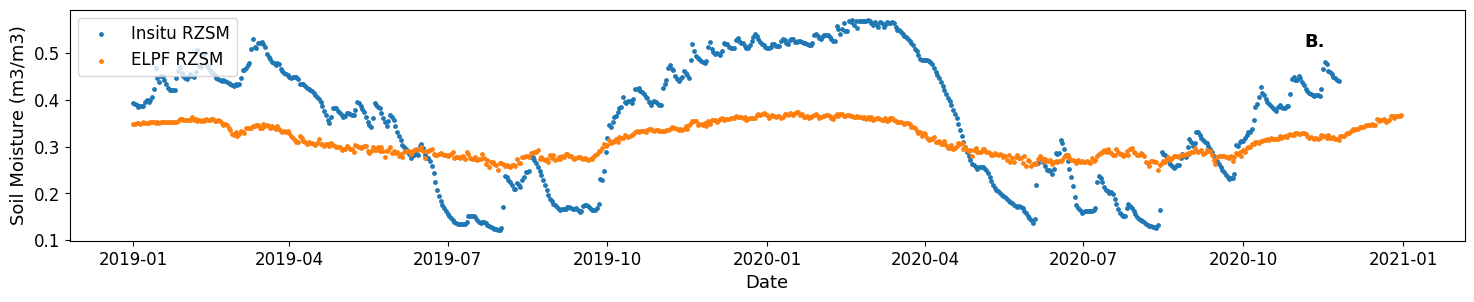

In [ ]:
plt.figure(figsize=(18, 3))
plt.scatter(val_data['Date'], val_data['Profile_40'], label="Insitu RZSM", s=6)
plt.scatter(val_gssm['Date'], val_gssm['rzsm_prd'], label="ELPF RZSM", s=6)


# Set labels and title
plt.xlabel('Date', fontsize=13)
plt.ylabel('Soil Moisture (m3/m3)', fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.legend(prop = { "size": 12 },loc='upper left')

# Remove grid
plt.grid(False)

# Add label inside plot
plt.text(0.9, 0.9, 'B.', fontsize=13, weight='bold', ha='right', va='top', transform=plt.gca().transAxes)

plt.show()